# Preprocess the data

In [11]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (17, 5)

In [5]:
AUDIO_DIR = '../data/genres/'

In [6]:
get_genre = lambda filename : filename.split('.')[0]

def get_filenames(audio_dir):
    """
    Get the filenames of all the aduio files.
    :param audio_dir: Path to the directory where all the audio files are stored.
    :return: List of all the filenames.
    """
    filenames = []
    for _, dirs, files in os.walk(audio_dir, topdown=False):
        if dirs == []:
            for file in files:
                filenames.append(file)
    return filenames

def get_path(audio_dir, filename):
    """
    Get the path of the audio file of the given filename.
    :param audio_dir: Path to the directory where all the audio files are stored.
    :param filename: filename of the audio file we want the path to.
    :return: The path to the audio file.
    """
    # Adds back leading zeros for the track ID we want.
    folder = get_genre(filename)
    # The audio file is stored in folders with the leading three digits of the audio filename.
    return os.path.join(audio_dir, folder, filename)

In [7]:
# Test functions work properly
filenames = get_filenames(AUDIO_DIR)
filenames.sort()
assert len(filenames) == 1000
assert get_path(AUDIO_DIR, filenames[0]) == '../data/genres/blues/blues.00000.wav'

## Feature Extraction: Mel-Spectrogram

The feature I will be extracting from the audio files is the Mel-Spectrogram. I will be storing all the spectrograms in the npz format.

In [8]:
SR = 22050
HOP_LENGTH = 1024
N_FFT = 2048
N_MELS = 128

def log_melspectrogram(filename, *, plot=False, genre_label=''):
    """
    Generate the log melspectrogram using an audio time series. Optionally this function will
    also plot the log melspectrogram.
    :param tid: Track ID of the audio file.
    :param plot: Bool value, when true the log melspectrogram generated will be plotted. 
                 By default this kwarg is set to false.
    :param genre_label: Genre label assosiated with the track.
    :return: The log melspectrogram
    """
    filepath = get_path(AUDIO_DIR, filename)
    
    y, _ = librosa.load(filepath)
    
    melspec = librosa.feature.melspectrogram(y=y, sr=SR, hop_length=HOP_LENGTH, n_fft=N_FFT, n_mels=N_MELS)

    melspec = librosa.power_to_db(melspec, ref=np.max)

    if plot:
            
        if genre_label != '':
            
            plt.title('Track {} --- Genre: {}'.format(filename, genre_label))
            
        else:
            
            plt.title('Track {}'.format(filename))
            
        librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    return melspec

In [14]:
def batch_create_log_melspectrograms(filenames):
    """
    Generate the log melspectrograms for all the tracks in the given pandas dataframe.
    :param df: Pandas dataframe containing the tracks to convert to log melspectrograms.
    :return: The array of log melspectrograms for all the tracks in the given dataframe and their genres.
    """
    melspecs = np.empty((0, 128, 640))
    genres = []
    
    for i, filename in enumerate(filenames):

        # Generate the log melspectrogram
        melspec = log_melspectrogram(filename)

        # Not all of the melspecs have the same dimensions, therefore, I decided to cut off 
        # anything after 640. This is just the time frame, so lossing some data here in the las couple ms.
        melspec = melspec[:,:640]

        # So in my experience np.concatenate is much faster than append.
        # Therefore we append the first element and then concatenate after for the 
        # rest of the elements.
        if i == 0:
            melspecs = np.append(melspecs, [melspec], axis=0)
        else:
            melspecs = np.concatenate((melspecs, [melspec]), axis=0)

        # Save genre
        genre = get_genre(filename)
        genres.append(genre)

        # Progress update
        if (i+1) % 100 == 0:
            print('Finished {} tracks'.format(i+1))
            
    melspecs = np.array(melspecs)
    labels = np.array(genres)
    
    return melspecs, labels

## Display a log Melspectrogram

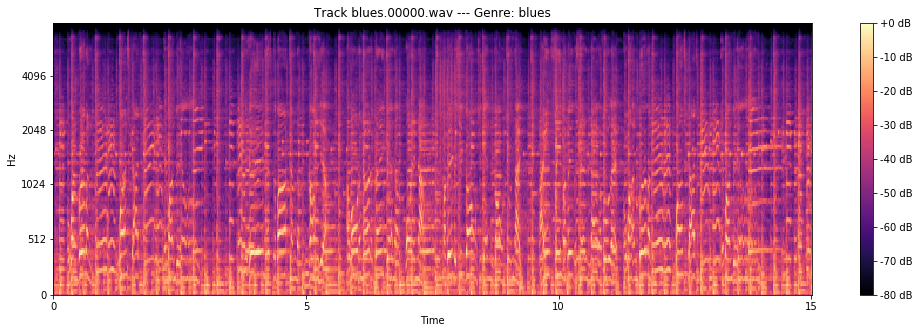

In [15]:
filename = filenames[0]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

## Create log Melspectrograms

In [16]:
melspecs, labels = batch_create_log_melspectrograms(filenames)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks


In [42]:
X_train, X_test, y_train, y_test = train_test_split(melspecs, labels, shuffle=True, test_size=0.1)

In [43]:
X_train.shape

(900, 128, 640)

In [44]:
unique, counts = np.unique(y_train, return_counts=True)
for (u, c) in zip(unique, counts):
    print('{} : {}'.format(u, c))

blues : 88
classical : 87
country : 90
disco : 95
hiphop : 94
jazz : 85
metal : 90
pop : 91
reggae : 86
rock : 94


The Distribution of genres is fairly evan, so we don't have to worry about our models being biased towards one genre.

## Encode Labels

In [45]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [46]:
label_train = le.transform(y_train)
label_test = le.transform(y_test)

In [47]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

## Store Data

In [48]:
np.savez('../data/melspects_128.npz', X_train=X_train, y_train=label_train, 
         X_test=X_test, y_test=label_test)